<a href="https://colab.research.google.com/github/cc-ca/Human_action_understanding/blob/cnn-rnn/CNN_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PACKAGES SETUP

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs 

  Preparing metadata (setup.py) ... done


In [ ]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import tensorflow as tf
import cv2
import random
import numpy as np
import imageio
from tensorflow_docs.vis import embed
from pathlib import Path
import random

#IMPORT THE DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#specify the path to the dataset
traindir = r"/content/drive/MyDrive/dataset/train"
valdir = r"/content/drive/MyDrive/dataset/val"
## Data preparation

In [ ]:
def extract_url_labels(dir):
    #create an empty pandas dataframe
    df = pd.DataFrame({'url': [], 'label': []})
    actions_dir = listdir(dir)
    for tmpdir in actions_dir:
        print(tmpdir)
        Lfiles = listdir(dir+"/"+tmpdir)
        #print(Lfiles)
        for video in Lfiles:
            df.loc[len(df)] = [dir + "/"+ tmpdir +"/"+ video, tmpdir]
    return(df)


In [ ]:
train_data =extract_url_labels(traindir)
train_data


applauding
cleaning toilet
doing nails
opening bottle (not wine)
petting cat
pillow fight
smoking
playing guitar
washing dishes
playing cards
stretching arm
vacuuming floor


,url,label
0,/content/drive/MyDrive/dataset/train/applaudin...,applauding
1,/content/drive/MyDrive/dataset/train/applaudin...,applauding
2,/content/drive/MyDrive/dataset/train/applaudin...,applauding
3,/content/drive/MyDrive/dataset/train/applaudin...,applauding
4,/content/drive/MyDrive/dataset/train/applaudin...,applauding
...,...,...
9673,/content/drive/MyDrive/dataset/train/vacuuming...,vacuuming floor
9674,/content/drive/MyDrive/dataset/train/vacuuming...,vacuuming floor
9675,/content/drive/MyDrive/dataset/train/vacuuming...,vacuuming floor
9676,/content/drive/MyDrive/dataset/train/vacuuming...,vacuuming floor


In [ ]:
val_data = extract_url_labels(valdir)
val_data

smoking
playing cards
pillow fight
washing dishes
applauding
stretching arm
opening bottle (not wine)
cleaning toilet
petting cat
vacuuming floor
doing nails
playing guitar


,url,label
0,/content/drive/MyDrive/dataset/val/smoking/2sM...,smoking
1,/content/drive/MyDrive/dataset/val/smoking/zGG...,smoking
2,/content/drive/MyDrive/dataset/val/smoking/-uB...,smoking
3,/content/drive/MyDrive/dataset/val/smoking/2fR...,smoking
4,/content/drive/MyDrive/dataset/val/smoking/1Dp...,smoking
...,...,...
575,/content/drive/MyDrive/dataset/val/playing gui...,playing guitar
576,/content/drive/MyDrive/dataset/val/playing gui...,playing guitar
577,/content/drive/MyDrive/dataset/val/playing gui...,playing guitar
578,/content/drive/MyDrive/dataset/val/playing gui...,playing guitar


In [ ]:
print("nobre de vidéos au total (train+validation) : "+ str(len(train_data)+len(val_data)))

nobre de vidéos au total (train+validation) : 10258


#Data preparation

##Shufffle

first, we shuffle the videos to make shure we are training evenly for each labels

In [ ]:
train_data=train_data.sample(frac=1).reset_index(drop=True)
train_data

,url,label
0,/content/drive/MyDrive/dataset/train/washing d...,washing dishes
1,/content/drive/MyDrive/dataset/train/vacuuming...,vacuuming floor
2,/content/drive/MyDrive/dataset/train/applaudin...,applauding
3,/content/drive/MyDrive/dataset/train/vacuuming...,vacuuming floor
4,/content/drive/MyDrive/dataset/train/stretchin...,stretching arm
...,...,...
9673,/content/drive/MyDrive/dataset/train/washing d...,washing dishes
9674,/content/drive/MyDrive/dataset/train/washing d...,washing dishes
9675,/content/drive/MyDrive/dataset/train/vacuuming...,vacuuming floor
9676,/content/drive/MyDrive/dataset/train/cleaning ...,cleaning toilet


In [ ]:
val_data=val_data.sample(frac=1).reset_index(drop=True)
val_data

,url,label
0,/content/drive/MyDrive/dataset/val/vacuuming f...,vacuuming floor
1,/content/drive/MyDrive/dataset/val/petting cat...,petting cat
2,/content/drive/MyDrive/dataset/val/applauding/...,applauding
3,/content/drive/MyDrive/dataset/val/pillow figh...,pillow fight
4,/content/drive/MyDrive/dataset/val/petting cat...,petting cat
...,...,...
575,/content/drive/MyDrive/dataset/val/opening bot...,opening bottle (not wine)
576,/content/drive/MyDrive/dataset/val/smoking/1Ev...,smoking
577,/content/drive/MyDrive/dataset/val/smoking/-KT...,smoking
578,/content/drive/MyDrive/dataset/val/vacuuming f...,vacuuming floor


##Video previsualitation with gif

to be able to quickly the action made in a video

In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [ ]:
def frames_from_video_file(video_path, n_frames, output_size = (244,244), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [ ]:
video_path=train_data['url'][400]
print(video_path)

/content/drive/MyDrive/dataset/train/cleaning toilet/w4TwxNp06RE_000165_000175.mp4


In [ ]:
sample_video = frames_from_video_file(video_path, n_frames = 10)
sample_video.shape

(10, 244, 244, 3)

In [ ]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


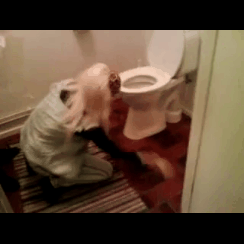

In [ ]:
to_gif(sample_video)

#DATA LOADER

##Variables

In [ ]:
n_frames = 2
bach_size_train = 1
bach_size_val = 1


How many vidéos you want to use

In [ ]:
test_data = val_data.iloc[251:].reset_index(drop=True)
train_data=train_data.head(1600)
val_data=val_data.head(250)

##Functions

In [ ]:
class FrameGenerator:
    def __init__(self, data, n_frames, training=False):
      
        """Returns a set of frames with their associated label.

        Args:
            data: Pandas DataFrame containing the video URLs and labels.
            n_frames: Number of frames.
            training: Boolean to determine if training dataset is being created.
        """
        self.path = data['url']
        self.n_frames = n_frames
        self.training = training
        self.class_names = sorted(list(set(data['label'])))
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        video_paths = [Path(p) for p in self.path.astype(str).tolist() if p.endswith('.mp4')]
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:

            video_frames = frames_from_video_file(path, self.n_frames)
            label = self.class_ids_for_name[name]  # Encode labels
            yield video_frames, label

In [ ]:
fg = FrameGenerator(train_data, 2, training=True)
frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (2, 244, 244, 3)
Label: 0


In [ ]:
train_data

,url,label
0,/content/drive/MyDrive/dataset/train/washing d...,washing dishes
1,/content/drive/MyDrive/dataset/train/vacuuming...,vacuuming floor
2,/content/drive/MyDrive/dataset/train/applaudin...,applauding
3,/content/drive/MyDrive/dataset/train/vacuuming...,vacuuming floor
4,/content/drive/MyDrive/dataset/train/stretchin...,stretching arm
...,...,...
1595,/content/drive/MyDrive/dataset/train/opening b...,opening bottle (not wine)
1596,/content/drive/MyDrive/dataset/train/cleaning ...,cleaning toilet
1597,/content/drive/MyDrive/dataset/train/opening b...,opening bottle (not wine)
1598,/content/drive/MyDrive/dataset/train/stretchin...,stretching arm


In [ ]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_data, n_frames, training=True),
                                          output_signature = output_signature)

In [ ]:
for frames, labels in train_ds.take(12):
  print(labels)

tf.Tensor(5, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(8, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(10, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(5, shape=(), dtype=int16)
tf.Tensor(5, shape=(), dtype=int16)


In [ ]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(val_data, n_frames),
                                        output_signature = output_signature)

In [ ]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (2, 244, 244, 3)
Shape of training labels: ()
Shape of validation set of frames: (2, 244, 244, 3)
Shape of validation labels: ()


In [ ]:
print(train_frames.shape)
print(train_labels.shape)
print(val_frames.shape)
print(val_labels.shape)
train_frames
train_labels


(2, 244, 244, 3)
()
(2, 244, 244, 3)
()


<tf.Tensor: shape=(), dtype=int16, numpy=11>

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

##Build the final data

In [ ]:
train_ds = train_ds.batch(bach_size_train)
val_ds = val_ds.batch(bach_size_val)

In [ ]:
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

Shape of training set of frames: (1, 2, 244, 244, 3)
Shape of training labels: (1,)


In [ ]:
val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of validation set of frames: (1, 2, 244, 244, 3)
Shape of validation labels: (1,)


In [ ]:
print(train_labels)

tf.Tensor([4], shape=(1,), dtype=int16)


#BUILD AND TRAIN THE MODEL

In [ ]:
drop_out=0.1
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.Dropout(drop_out),
    
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dropout(drop_out),

        tf.keras.layers.Dense(1024),
    tf.keras.layers.Dropout(drop_out),


    
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(drop_out),
    

    tf.keras.layers.Dense(232),
    tf.keras.layers.Dropout(drop_out),



    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(drop_out),

    tf.keras.layers.Dense(96),
    tf.keras.layers.Dropout(drop_out),
    
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dropout(drop_out),

    tf.keras.layers.Dense(32),
    tf.keras.layers.Dropout(drop_out),

    tf.keras.layers.Dense(24),
    tf.keras.layers.Dropout(drop_out),

    tf.keras.layers.Dense(12),#, activation="softmax"
    tf.keras.layers.Dropout(drop_out),
    
    tf.keras.layers.GlobalAveragePooling3D()
    
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])




model.build((20, 2, 244, 244, 3))
model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (20, 2, 244, 244, 3)      0         
                                                                 
 dropout (Dropout)           (20, 2, 244, 244, 3)      0         
                                                                 
 time_distributed (TimeDistr  (20, 2, 7, 7, 1280)      4049571   
 ibuted)                                                         
                                                                 
 dropout_1 (Dropout)         (20, 2, 7, 7, 1280)       0         
                                                                 
 dense (Dense)               (20, 2, 7, 7, 1024)       1311744   
                                                                 
 dropout_2 (Dropout)         (20, 2, 7, 7, 1024)       0 

In [ ]:
model.fit(train_ds, 
          epochs = 10,
          validation_data = val_ds,
          callbacks = tf.keras.callbacks.EarlyStopping(patience = 30, monitor = 'val_loss'))

Epoch 1/10
1600/1600 [==============================] - 29s 18ms/step - loss: 2.0215 - accuracy: 0.4963 - val_loss: 1.8145 - val_accuracy: 0.4360
Epoch 2/10
1600/1600 [==============================] - 29s 18ms/step - loss: 1.2607 - accuracy: 0.5881 - val_loss: 1.6048 - val_accuracy: 0.4800
Epoch 3/10
1600/1600 [==============================] - 29s 18ms/step - loss: 1.2705 - accuracy: 0.5856 - val_loss: 1.6288 - val_accuracy: 0.4760
Epoch 4/10
1600/1600 [==============================] - 28s 18ms/step - loss: 1.2402 - accuracy: 0.5719 - val_loss: 1.9328 - val_accuracy: 0.4240
Epoch 5/10
1600/1600 [==============================] - 29s 18ms/step - loss: 1.2300 - accuracy: 0.6025 - val_loss: 1.5607 - val_accuracy: 0.5200
Epoch 6/10
1600/1600 [==============================] - 28s 18ms/step - loss: 1.1550 - accuracy: 0.6263 - val_loss: 1.7716 - val_accuracy: 0.5080
Epoch 7/10
1600/1600 [==============================] - 29s 18ms/step - loss: 1.1095 - accuracy: 0.6288 - val_loss: 1.6524 -

#EXPORT/IMPORT THE MODEL

In [ ]:
#tf.saved_model.save(model, r"/content/drive/MyDrive/dataset/model")

In [ ]:
# Charger le modèle TensorFlow
#loaded_model = tf.saved_model.load(r"/content/drive/MyDrive/dataset/model")

# Utiliser le modèle pour faire des prédictions
#result = loaded_model.predict(inputs)

#USE OUR TRAINED MODEL TO MAKE SOME PREDICTIONS

## select a video

In [ ]:
i_rand = random.randint(0,329)
print(i_rand)

133


In [ ]:
video_test_index = i_rand

In [ ]:
test_predict= test_data.iloc[[i_rand]] # double crochets pour extraire sous forme de dataframe
test_predict

,url,label
133,/content/drive/MyDrive/dataset/val/vacuuming f...,vacuuming floor


In [ ]:
L_labels = sorted(list(set(test_data['label'])))

##generate a gif to see the video

In [ ]:
video_path=test_predict['url'][video_test_index]
print(video_path)

/content/drive/MyDrive/dataset/val/vacuuming floor/c1pKnSEDueU_000026_000036.mp4


In [ ]:
sample_video = frames_from_video_file(video_path, n_frames = 10)
sample_video.shape

(10, 244, 244, 3)

In [ ]:
video_path=test_predict['label'][video_test_index]
print(video_path)

vacuuming floor



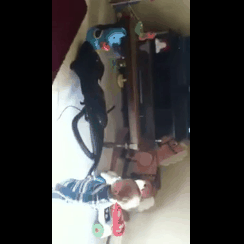

In [ ]:
to_gif(sample_video)

##process the video to be able to make a prediction

In [ ]:
print(type(test_predict))
print(type(train_data))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_predict,n_frames ),
                                        output_signature = output_signature)

In [ ]:
test_frames, test_labels = next(iter(test_ds))
print(f'Shape of test set of frames: {test_frames.shape}')
print(f'Shape of test labels: {test_labels.shape}')

Shape of test set of frames: (2, 244, 244, 3)
Shape of test labels: ()


In [ ]:
print(test_frames.shape)
print(test_labels.shape)
test_frames
test_labels

(2, 244, 244, 3)
()


<tf.Tensor: shape=(), dtype=int16, numpy=0>

In [ ]:
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [ ]:
test_ds = test_ds.batch(bach_size_val)

In [ ]:
test_frames, test_labels = next(iter(test_ds))
print(f'Shape of training set of frames: {test_frames.shape}')
print(f'Shape of training labels: {test_labels.shape}')

Shape of training set of frames: (1, 2, 244, 244, 3)
Shape of training labels: (1,)


In [ ]:
for test_frames, test_labels in test_ds.take(1):
  print(test_labels)

tf.Tensor([0], shape=(1,), dtype=int16)


##predict

In [ ]:
prediction = model.predict(test_frames)

1/1 [==============================] - 0s 46ms/step


In [ ]:
print(test_labels)

tf.Tensor([0], shape=(1,), dtype=int16)


##Result of the prediction


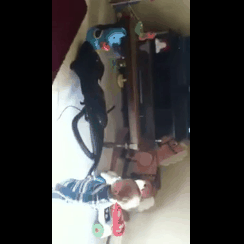

In [ ]:
to_gif(sample_video)

In [ ]:
print(video_path)

vacuuming floor


In [ ]:
label = np.argmax(prediction, axis=1)
print(L_labels[int(label)]+ " is recognised")

vacuuming floor is recognised


##test

In [ ]:
L= ["applauding","cleaning toilet","doing nails","opening bottle (not wine)","petting cat","pillow fight","smoking","playing guitar","washing dishes","playing cards","stretching arm","vacuuming floor",]
print(len(L))

12


In [ ]:
index = val_data.loc[val_data['label'] == 'smoking'].index[12]

print(index)


206
